In [ ]:
pip install torchaudio

     |████████████████████████████████| 1.9 MB 5.4 MB/s 
     |████████████████████████████████| 831.4 MB 6.9 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.


In [ ]:
pip install git+https://github.com/ContinualAI/avalanche.git

  Cloning https://github.com/ContinualAI/avalanche.git to /tmp/pip-req-build-k9bj0taj
  Running command git clone -q https://github.com/ContinualAI/avalanche.git /tmp/pip-req-build-k9bj0taj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 131 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.7 MB 43.2 MB/s 
     |████████████████████████████████| 532 kB 48.5 MB/s 
     |████████████████████████████████| 180 kB 47.2 MB/s 
     |████████████████████████████████| 139 kB 49.1 MB/s 
     |████████████████████████████████| 97 kB 7.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for avalanche-lib: filename=avalanche_lib-0.0.1-py3-none-any.whl size=410544 sha256=4838cdd760246f33cadbc018feb649fdb747cde2d99d1cebca2c953db

In [1]:
import os
import torchaudio
from torch import Tensor
from torch.nn import Module
from torch.utils.data import Dataset
from torchaudio.datasets.utils import download_url, extract_archive
import librosa
import numpy
from typing import Tuple
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from avalanche.benchmarks import NCScenario, nc_benchmark, ni_benchmark

In [2]:
def add_white_noise(x, rate=0.002):
        return x + rate*np.random.randn(len(x))

    # data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

    # data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]

In [3]:

# Download URL and checksums
URL = {
    "esc-10": "https://github.com/karoldvl/ESC-50/archive/master.zip",
    "esc-50": "https://github.com/karoldvl/ESC-50/archive/master.zip",
    # "esc-us": None,
}

_CHECKSUMS = {
    "esc-10": None,
    "esc-50": None,
    # "esc-us": None,
}

# Constant
ARCHIVE_BASENAME = "ESC-50-master"
FOLDER_IN_ARCHIVE = "ESC-50-master"
AUDIO_FOLDER = "audio"
META_FOLDER = "meta"
AVAILABLE_VERSION = list(URL.keys())

# Default parameters
FOLDS = (1, 2, 3, 4, 5)


class ESC50(Dataset):
    """
    ESC datasets
    Args:
        root (string): Root directory of datasets where directory
            ``ESC-50-master`` exists or will be saved to if download is set to True.
        download (bool, optional): If true, download the dataset from the internet
            and puts it in root directory. If datasets is already downloaded, it is
            not downloaded again.
    """
    NB_CLASS = 50

    def __init__(self,
                 root: str,
                 train: bool = True,
                 folds: tuple = FOLDS,
                  data_aug=False,
                 download: bool = False,
                 transform: Module = None) -> None:

        super().__init__()
        self.train = train
        self.root = root
        self.required_folds = folds
        self.transform = transform
        self.data_aug = data_aug
        self.url = URL["esc-50"]
        self.nb_class = 50
        self.target_directory = os.path.join(self.root, FOLDER_IN_ARCHIVE)

        # Dataset must exist to continue
        if download:
            self.download()
        # elif not self.check_integrity(self.target_directory):
        #     raise RuntimeError("Dataset not found or corrupted. \n\
        #         You can use download=True to download it.")

        # Prepare the medata
        self._filenames = []
        self._folds = []
        self.targets = []
        self._esc10s = []
        self._load_metadata()
    
    def add_white_noise(x, rate=0.002):
        return x + rate*np.random.randn(len(x))

    # data augmentation: shift sound in timeframe
    def shift_sound(x, rate=2):
        return np.roll(x, int(len(x)//rate))

    # data augmentation: stretch sound
    def stretch_sound(x, rate=1.1):
        input_length = len(x)
        x = librosa.effects.time_stretch(x, rate)
        if len(x)>input_length:
            return x[:input_length]
    def __getitem__(self, index: int) -> Tuple[Tensor, int]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (raw_audio, sr, target).
        """
        
        
        data, target = self.load_item(index)
        # augumentations in wave domain.
        
        if self.data_aug:
            r = np.random.rand()
            if r < 0.3:
                data = add_white_noise(data)

            r = np.random.rand()
            if r < 0.3:
                data = shift_sound(data, rate=1+np.random.rand())

            r = np.random.rand()
            if r < 0.3:
                data = stretch_sound(data, rate=0.8+np.random.rand()*0.4)
        
        if self.transform is not None:
            data = self.transform(data)
            data = data.squeeze()
        
        return data, target

    def __len__(self) -> int:
        return len(self._filenames)

    def _load_metadata(self) -> None:
        
        """Read the metadata csv file and gather the information needed."""
        # HEADER COLUMN NUMBER
        c_filename = 0
        c_fold = 1
        c_target = 2
        c_esc10 = 4

        # Read the csv file and remove header
        path = os.path.join(self.target_directory, META_FOLDER, "esc50.csv")
        
        with open(path, "r") as fp:
            data = fp.read().splitlines()[1:]
            
            for line in data:
                items = line.split(",")
                if self.train:
                  if int(items[c_fold]) < 5:
                    self._filenames.append(items[c_filename])
                    self._folds.append(int(items[c_fold]))
                    self.targets.append(int(items[c_target]))
                    self._esc10s.append(eval(items[c_esc10]))
                else:
                  if int(items[c_fold]) == 5:
                    self._filenames.append(items[c_filename])
                    self._folds.append(int(items[c_fold]))
                    self.targets.append(int(items[c_target]))
                    self._esc10s.append(eval(items[c_esc10]))

        self._filenames = numpy.asarray(self._filenames)
        self._folds = numpy.asarray(self._folds)
        self.targets = numpy.asarray(self.targets)
        self._esc10s = numpy.asarray(self._esc10s)

        # Keep only the required folds
        

        
        folds_mask = sum([self._folds == f for f in self.required_folds]) >= 1
        
        self._filenames = self._filenames[folds_mask]
        self.targets = self.targets[folds_mask]
        self._esc10s = self._esc10s[folds_mask]

    def download(self) -> None:
        
        """Download the dataset and extract the archive"""
        if self.check_integrity(self.target_directory):
            
            print("Dataset already downloaded and verified.")

        else:
            
            archive_path = os.path.join(self.root, FOLDER_IN_ARCHIVE + ".zip")
            
            download_url(self.url, self.root)
            extract_archive(archive_path, self.root)
    # data augmentation: add white noise
    
    def check_integrity(self, path, checksum=None) -> bool:
        
        """Check if the dataset already exist and if yes, if it is not corrupted.
        Returns:
            bool: False if the dataset doesn't exist or if it is corrupted.
        """
        if not os.path.isdir(path):
            return False

        # TODO add checksum verification
        return True

    def load_item(self, index: int) -> Tuple[Tensor, int]:
        
        filename = self._filenames[index]
        target = self.targets[index]

        path = os.path.join(self.target_directory, AUDIO_FOLDER, filename)
        waveform, sample_rate = librosa.load(path, sr=44100)
        
        # waveform, sample_rate = torchaudio.load(path)
        
        return waveform, target

In [4]:
train_dataset = ESC50(root= os.path.abspath(os.getcwd()),download =True, data_aug=False, train=True)
test_dataset = ESC50(root= os.path.abspath(os.getcwd()),download =True, data_aug=False, train=False)

'''

total_count = len(dataset)
train_count = int(0.8 * total_count)
#valid_count = int(0.1 * total_count)
valid_count = 0
test_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
train_dataset, test_dataset = torch.utils.data.random_split(   # Change random splits to Fold split
    dataset, [1800, 200]
)

'''


#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)

Dataset already downloaded and verified.
Dataset already downloaded and verified.


'\n\ntotal_count = len(dataset)\ntrain_count = int(0.8 * total_count)\n#valid_count = int(0.1 * total_count)\nvalid_count = 0\ntest_count = int(0.2 * total_count)\ntest_count = total_count - train_count - valid_count\ntrain_dataset, test_dataset = torch.utils.data.random_split(   # Change random splits to Fold split\n    dataset, [1800, 200]\n)\n\n'

In [5]:
scenario = nc_benchmark(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            n_experiences=5,
            task_labels=True,
            seed=1,
            fixed_class_order=None,
            shuffle=True,
            class_ids_from_zero_in_each_exp=True)

In [6]:
scenario2 = ni_benchmark(
            train_dataset, test_dataset, 5, shuffle=True, seed=1234,
            balance_experiences=True)

In [7]:
def show_wave(x):
    plt.plot(x)
    plt.show()
    
def check_audio_benchmark(benchmark_instance):
  print('The benchmark instance contains',
  len(benchmark_instance.train_stream), 'training experiences.')

  for i, exp in enumerate(benchmark_instance.train_stream):
      dataset, t = exp.dataset, exp.task_label
    

      dl = DataLoader(dataset, batch_size=300)
      print('Train experience', exp.current_experience)
      for x, y, z in dl.dataset:
        show_wave(x)
        break

The benchmark instance contains 5 training experiences.
Train experience 0


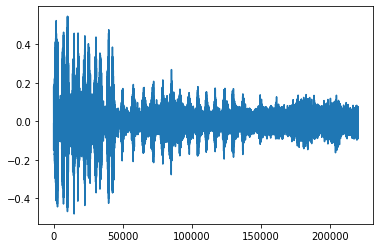

Train experience 1


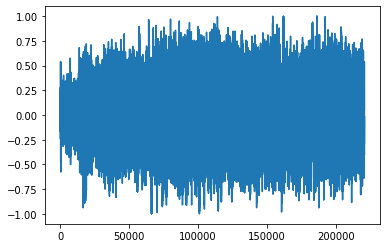

Train experience 2


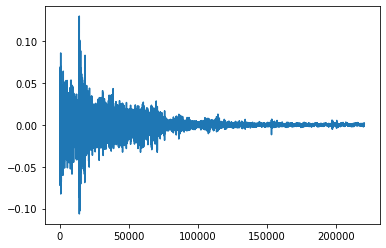

Train experience 3


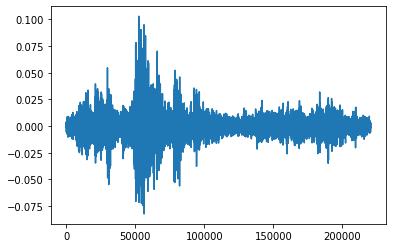

Train experience 4


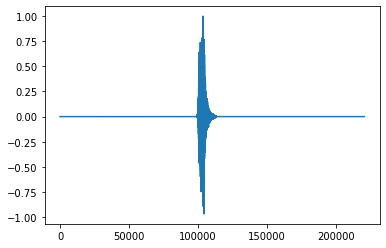

In [8]:
check_audio_benchmark(scenario)

In [9]:
train_stream = scenario.train_stream
print(train_stream.name)

# we have access to the scenario from which the stream was taken
train_stream.benchmark

# we can slice and reorder the stream as we like!
substream = train_stream[0]
substream = train_stream[0:2]
substream = train_stream[0,2,1]

len(substream)

train


3

In [10]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

# iterating over the train stream
for experience in train_stream:
  print("Start of task ", experience.task_label)
  print('Classes in this task:', experience.classes_in_this_experience)
  
  # The current Pytorch training set can be easily recovered through the
  # experience
  current_training_set = experience.dataset
  # ...as well as the task_label
  print('Task {}'.format(experience.task_label))
  print('This task contains', len(current_training_set), 'training examples')

  # we can recover the corresponding test experience in the test stream
  current_test_set = test_stream[experience.current_experience].dataset
  print('This task contains', len(current_test_set), 'test examples')

Start of task  0
Classes in this task: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Task 0
This task contains 320 training examples
This task contains 80 test examples
Start of task  1
Classes in this task: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Task 1
This task contains 320 training examples
This task contains 80 test examples
Start of task  2
Classes in this task: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Task 2
This task contains 320 training examples
This task contains 80 test examples
Start of task  3
Classes in this task: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Task 3
This task contains 320 training examples
This task contains 80 test examples
Start of task  4
Classes in this task: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Task 4
This task contains 320 training examples
This task contains 80 test examples


In [11]:
import torch.nn as nn
import torchaudio.transforms as T
import random
class AudioNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        filt_size = (3, 3)
        pool_size = (2, 2)
        num_classes=10
        # Create melspectrograms 
        self.mel_spectrogram = T.MelSpectrogram(
          sample_rate=48000,
          n_mels=128,
          n_fft = 2048,
          hop_length = 242
          )
        self.use_bias = True
        self.b_norm2d = nn.BatchNorm2d(1)
        self.mlp = nn.Sequential(
            
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128,num_classes),
            nn.Softmax(dim=1)

        )

        self.pool = nn.Sequential(
            nn.MaxPool2d((16,24)),
            nn.Flatten()           
            
        )
        self.conv = nn.Sequential(
            nn.BatchNorm2d(1),
            #block1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=filt_size, bias=self.use_bias, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=filt_size, bias=self.use_bias, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool_size, stride=2),

            #block2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=filt_size, bias=self.use_bias,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=filt_size, bias=self.use_bias, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool_size, stride=2),

            #block3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=filt_size, bias=self.use_bias, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=filt_size, bias=self.use_bias, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool_size, stride=2),

            #block4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=filt_size, bias=self.use_bias, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=filt_size, bias=self.use_bias, padding=1),
        )
    @staticmethod
    def get_Random_One_Sec_Audio_Sample(X):
          sample_len = X.shape[1]
          st = random.randint(0,sample_len-48000)
          end = st+48000
          samples = X[:,st:end].clone()
          #print(samples.shape)
          return samples

    @staticmethod
    def get_Audio_Set_For_Test(X):
          X = X.unfold(1,48000,24000)
          return X.swapaxes(0,1)

    def transform_to_melSpectogram(self,aud_batch):
          melspec = self.mel_spectrogram(aud_batch)
          return melspec.unsqueeze(1)
        

    def forward(self, X: torch.Tensor):
      #print('here')
      if self.training:
            #X is batch of data sample (batch_size x sample_rate)
            
            #Take 1s sample at randmom
            samples = self.get_Random_One_Sec_Audio_Sample(X) # 32 1s samples
            #print(samples.shape)
            #Mel transform
            inp = self.transform_to_melSpectogram(samples) # batch of 32 1s mel-spectrograms
            #print(inp.shape)
            output = self.conv(inp) #batch of 32*512 vector values
            #print(output.shape)
            output = self.pool(output)
            #print(output.shape)
            #MLP 
            output = self.mlp(output)
            return output
      else:
          # X is a set of batches with repeated classes
          audio_set = self.get_Audio_Set_For_Test(X)
          # Loop over the samples in the batch audio_set.shape[0]
          outputs = torch.empty(9,audio_set.shape[1],50)
          for i,sample_set in enumerate(audio_set):
            #print(sample_set.shape)
            inp = self.transform_to_melSpectogram(sample_set)
            #print(inp.shape)
              #Batch Norm
            inp = self.b_norm2d(inp)
            output = self.conv(inp) #512 values
            output = self.pool(output)
            #MLP 
            output = self.mlp(output)

            outputs[i]=output          
          
          return outputs.mean(dim=0)

In [12]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.models import SimpleMLP, MTSimpleMLP
from avalanche.training.strategies import EWC

model2 = AudioNetwork()
model = SimpleMLP(input_size=220500)
model3 = MTSimpleMLP(input_size=220500)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()





In [13]:
cl_strategy = EWC(
    model, optimizer, criterion, ewc_lambda=0.4,
    train_mb_size=1, train_epochs=3, eval_mb_size=1
)


cl_strategy2 = EWC(
    model2, optimizer, criterion, ewc_lambda=0.4,
    train_mb_size=1, train_epochs=3, eval_mb_size=1
)

In [ ]:
results

[]

In [14]:
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    results.append(cl_strategy.eval(scenario.test_stream))
    #print(cl_strategy.eval(scenario.test_stream))
    print('**************************************')

Starting experiment...
Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start of training phase << --
-- Starting training on experience 0 (Task 0) from train stream --
100%|██████████| 320/320 [03:23<00:00,  1.58it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2929
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1125
100%|██████████| 320/320 [03:20<00:00,  1.59it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2868
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8063
100%|██████████| 320/320 [03:20<00:00,  1.60it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8426
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9344
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 80/80 [00:04<00:00, 17.19it/s]
> Eval on experience 0 (Task 0) fr

**Confronto con Permuted Mnist**

In [ ]:
from avalanche.benchmarks.classic import CORe50, SplitTinyImageNet, \
SplitCIFAR10, SplitCIFAR100, SplitCIFAR110, SplitMNIST, RotatedMNIST, \
PermutedMNIST, SplitCUB200, SplitImageNet

# creating PermutedMNIST (Task-Incremental)
perm_mnist = PermutedMNIST(
    n_experiences=2,
    seed=1234,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/.avalanche/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/.avalanche/data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/.avalanche/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.avalanche/data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.avalanche/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.avalanche/data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/.avalanche/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.avalanche/data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_stream = perm_mnist.train_stream
test_stream = perm_mnist.test_stream

# iterating over the train stream
for experience in train_stream:
  print("Start of task ", experience.task_label)
  print('Classes in this task:', experience.classes_in_this_experience)
  
  # The current Pytorch training set can be easily recovered through the
  # experience
  current_training_set = experience.dataset
  # ...as well as the task_label
  print('Task {}'.format(experience.task_label))
  print('This task contains', len(current_training_set), 'training examples')

  # we can recover the corresponding test experience in the test stream
  current_test_set = test_stream[experience.current_experience].dataset
  print('This task contains', len(current_test_set), 'test examples')

Start of task  0
Classes in this task: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Task 0
This task contains 60000 training examples
This task contains 10000 test examples
Start of task  1
Classes in this task: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Task 1
This task contains 60000 training examples
This task contains 10000 test examples


In [ ]:
from avalanche.benchmarks.classic import SplitMNIST, core50

#benchmark = CORe50(scenario="nc")

# scenario
scenario2 = SplitMNIST(n_experiences=5, seed=1)

In [ ]:
class MyStrategy():
    """My Basic Strategy"""

    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, experience):
        # here you can implement your own training loop for each experience (i.e. 
        # batch or task).

        train_dataset = experience.dataset
        t = experience.task_label
        train_data_loader = DataLoader(
            train_dataset, num_workers=4, batch_size=128
        )

        for epoch in range(1):
            for mb in train_data_loader:
                # you magin here...
                pass

    def test(self, experience):
        # here you can implement your own test loop for each experience (i.e. 
        # batch or task).

        test_dataset = experience.dataset
        t = experience.task_label
        test_data_loader = DataLoader(
            test_dataset, num_workers=4, batch_size=128
        )

        # test here

In [ ]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.models import SimpleMLP
from avalanche.training.strategies import EWC

model = SimpleMLP(num_classes=scenario.n_classes)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

cl_strategy = MyStrategy(model, optimizer, criterion)


In [ ]:
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    #results.append(cl_strategy.eval(scenario.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training completed
Computing accuracy on the whole test set
Start of experience:  1
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Training completed
Computing accuracy on the whole test set
Start of experience:  2
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Training completed
Computing accuracy on the whole test set
Start of experience:  3
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Training completed
Computing accuracy on the whole test set
Start of experience:  4
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Training completed
Computing accuracy on the whole test set


In [ ]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.models import SimpleMLP
from avalanche.training.strategies import EWC


model = SimpleMLP()
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()
cl_strategy = EWC(
    model, optimizer, criterion, ewc_lambda=0.4,
    train_mb_size=100, train_epochs=4, eval_mb_size=100
)


In [ ]:
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    MyStrategy.train()
    print('Training completed')

    print('Computing accuracy on the whole test set')
    results.append(cl_strategy.eval(scenario.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


TypeError: ignored